In [1]:
import process as pc
from IPython.core.interactiveshell import InteractiveShell

from sklearn.svm import LinearSVC
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from skimage import img_as_float
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import joblib
import cv2

from sklearn.decomposition import PCA
import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [2]:
positive_images_path = pc.DATA_PATH+"/img_align_celeba"
negative_images_path = pc.DATA_PATH+"/caltech-101/101_ObjectCategories"

pc.extract_dataset(positive_images_path)
bad_imgs_path_list = pc.extract_dataset(negative_images_path, folder="multi_folders")

Dataset already extracted


In [3]:
n_good_images = 20000
n_bad_images_folder=1000
size_w = size_h = 128

#count bad images:
bad_img_list = []
for fld in bad_imgs_path_list:
    tmp_img_list = pc.load_images(negative_images_path+"/"+fld, number_of_images=n_bad_images_folder, random_seed=7)
    bad_img_list += [negative_images_path+"/"+fld+'/'+img for img in tmp_img_list]

len(bad_img_list)


/home/enrico/Machine_learning/face_detection_project/src/user_warnings.py:4: UserWarning: The requested number of images is greater than the number of images in the folder
  warnings.warn("The requested number of images is greater than the number of images in the folder", UserWarning)


8275

In [4]:
#extract patch from bad images to increase the number of negative samples
bad_patches = pc.extract_patches(bad_img_list, (size_w, size_h), n_patches=25000, random_seed=7)
len(bad_patches)


2


23837

In [5]:
img_list = pc.load_images(positive_images_path, number_of_images=n_good_images, random_seed=7) 
images = np.empty((n_good_images, size_w, size_h), dtype=np.uint8)

for i, img in enumerate(img_list):
    image = cv2.imread(pc.DATA_PATH+"/img_align_celeba/"+img)
    images[i, ...] = pc.process_image(image, resize=True, img_resize=(size_w, size_h))

In [6]:
bad_images = np.empty((len(bad_patches), size_w, size_h), dtype=np.uint8)

for i, img in zip(range(len(bad_patches)), bad_patches):
    bad_images[i, ...] = pc.process_image(img, resize=True, img_resize=(size_w, size_h))

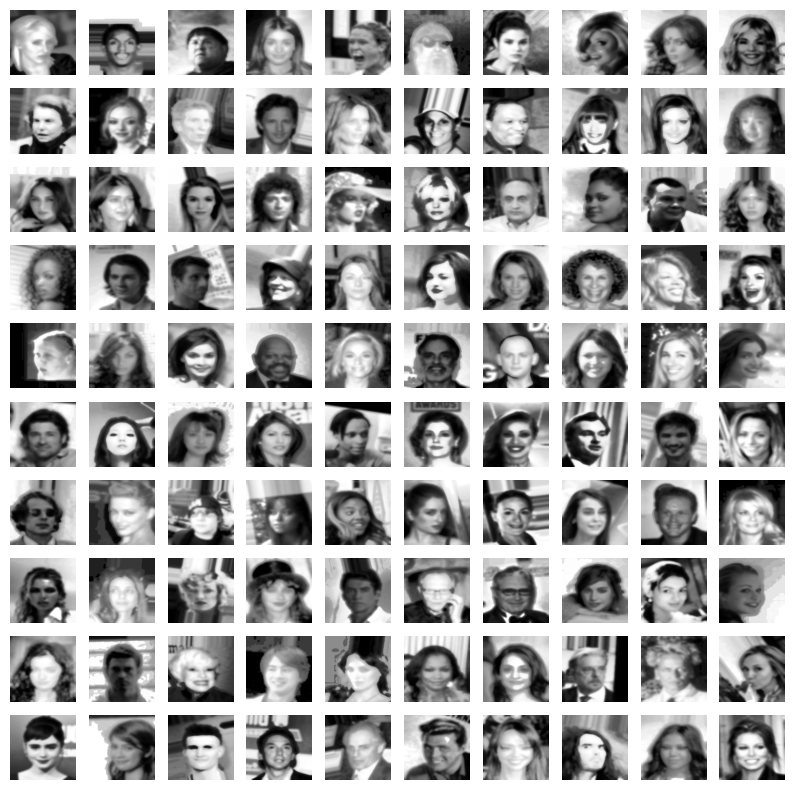

In [7]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images[i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

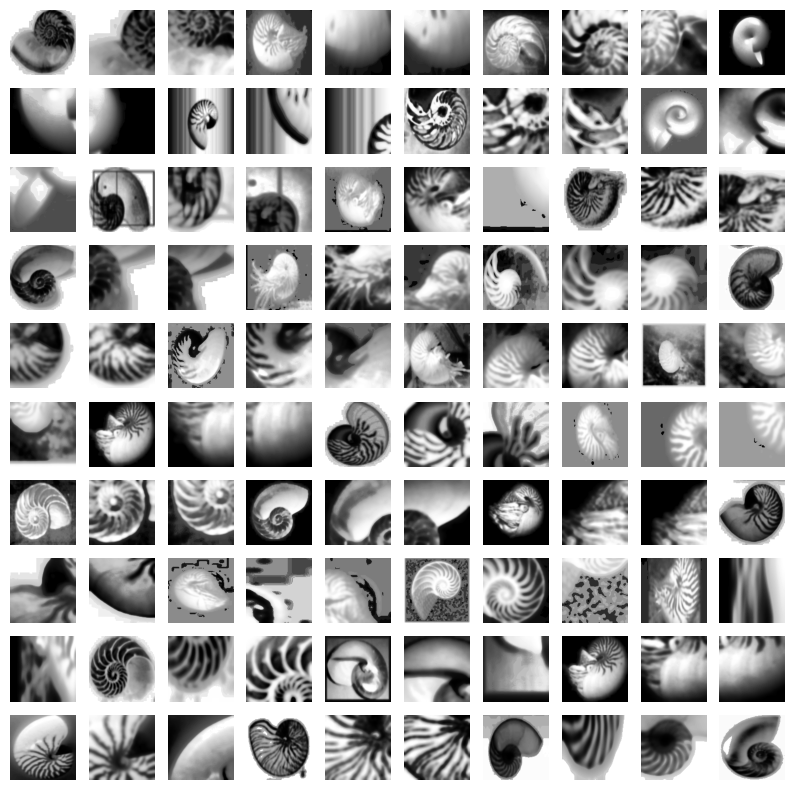

In [8]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(bad_images[i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

In [9]:
images.shape
bad_images.shape

(20000, 128, 128)

(23837, 128, 128)

In [10]:
dataset = np.concatenate((images, bad_images), axis=0)
dataset.shape

(43837, 128, 128)

In [11]:
features_extractor = "SIFT"
good_samples = n_good_images
bad_samples = bad_images.shape[0]
n_keypoints = 32
n_features = 128#256
if features_extractor == "ORB":
   ftr_shape = n_keypoints*n_features
   init = False
   for i, img in enumerate(dataset):
      _, features = pc.extract_ORB_features(img, n_keypoints=32)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
      features = features.flatten()
      if features.shape[0] == ftr_shape:
         if not init:
            X = np.array([features])
            init = True
         else:
            X = np.append(X, [features], axis=0)
      else:
         if i < good_samples:
            print("good sample")
            good_samples -= 1
         else:
            print("bad sample")
            bad_samples -= 1


if features_extractor == "SIFT":
   ftr_shape = n_keypoints*n_features
   init = False
   for i, img in enumerate(dataset):
      kp, features = pc.extract_SIFT_features(img, n_optimal_keypoints=n_keypoints)
      if len(kp) < n_keypoints:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue

      features = features.flatten()
      if features.shape[0] == ftr_shape:
         if not init:
            X = np.array([features])
            init = True
         else:
            X = np.append(X, [features], axis=0)
      else:
         if i < good_samples:
            print("good sample")
            good_samples -= 1
         else:
            print("bad sample")
            bad_samples -= 1
         


In [12]:
features.shape[0] == ftr_shape

True

In [13]:
good_samples
bad_samples
y = np.concatenate((np.ones(good_samples), np.zeros(bad_samples))) 
X.shape
y.shape

18059

14805

(32864, 4096)

(32864,)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=7)

In [15]:
X_train.shape
y_train.shape

X_train[0]
y_train[0]


(32206, 4096)

(32206,)

array([  1.,  67., 139., ...,  11.,  55.,  11.], dtype=float32)

1.0

In [16]:
X_train_pca = X_train
X_test_pca = X_test

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)
X_train_scaled[0]

array([0.00581395, 0.38068184, 0.83233535, ..., 0.06918239, 0.3021978 ,
       0.055     ], dtype=float32)

In [25]:
param_grid = {  'C' : [np.power(10., i) for i in range(-2, 2)],
                'max_iter' : [7500],
                'random_state' : [7],
                'dual' : ['auto'],
                'verbose': [1]  }

grid_searh = GridSearchCV(LinearSVC(), param_grid, cv=5, n_jobs=4)
grid_searh.fit(X_train_scaled, y_train)
grid_searh.best_params_

[LibLinear][LibLinear][LibLinear][LibLinear]iter  1 act 1.080e+02 pre 1.048e+02 delta 1.201e+00 f 2.576e+02 |g| 5.338e+02 CG   4
iter  1 act 1.104e+02 pre 1.070e+02 delta 1.208e+00 f 2.576e+02 |g| 5.356e+02 CG   4
cg reaches trust region boundary
iter  2 act 1.992e+01 pre 1.851e+01 delta 1.303e+00 f 1.496e+02 |g| 5.283e+01 CG   5
cg reaches trust region boundary
iter  2 act 2.037e+01 pre 1.884e+01 delta 1.334e+00 f 1.472e+02 |g| 5.328e+01 CG   6
iter  1 act 1.100e+02 pre 1.067e+02 delta 1.195e+00 f 2.576e+02 |g| 5.358e+02 CG   4
iter  1 act 1.095e+02 pre 1.061e+02 delta 1.194e+00 f 2.576e+02 |g| 5.353e+02 CG   4
cg reaches trust region boundary
cg reaches trust region boundary
iter  3 act 8.322e+00 pre 8.165e+00 delta 1.351e+00 f 1.297e+02 |g| 3.379e+01 CG   7
iter  3 act 7.912e+00 pre 7.755e+00 delta 1.383e+00 f 1.268e+02 |g| 3.094e+01 CG   6
cg reaches trust region boundary
iter  2 act 1.999e+01 pre 1.853e+01 delta 1.315e+00 f 1.477e+02 |g| 5.360e+01 CG   6
cg reaches trust region bo

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'dual': ['auto'],
                         'max_iter': [7500], 'random_state': [7],
                         'verbose': [1]})

{'C': 0.01, 'dual': 'auto', 'max_iter': 7500, 'random_state': 7, 'verbose': 1}

In [26]:
best_svc = grid_searh.best_estimator_

best_svc.score(X_train_scaled, y_train)

best_svc.score(X_test_scaled, y_test)

0.8537850090045334

0.8115501519756839

In [27]:
y_pred = best_svc.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy test:", accuracy)


y_pred = best_svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy test:", accuracy)

Accuracy test: 0.8537850090045334
Accuracy test: 0.8115501519756839


In [28]:
X_test_scaled[0]

array([0.        , 0.        , 0.        , ..., 0.        , 0.01098901,
       0.315     ], dtype=float32)

In [29]:
pipeline_save_path = pc.DATA_PATH+"/sift_features_32.pkl"

from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('preprocess', pc.process_image),
        ('normalize', scaler),
        ('extract_features', pc.extract_SIFT_features),
        ('svc', best_svc)  
    ])

joblib.dump(
    pipeline, pipeline_save_path
    )

['../data/sift_features_32.pkl']

[1] [0.67899929]


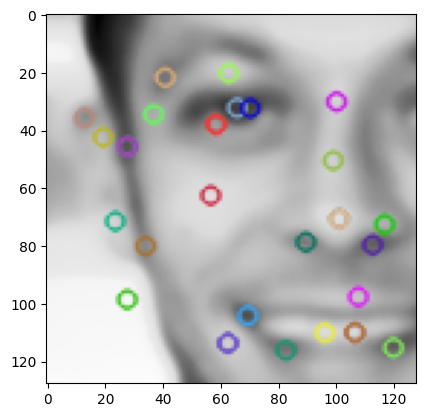

[0] [0.37932145]


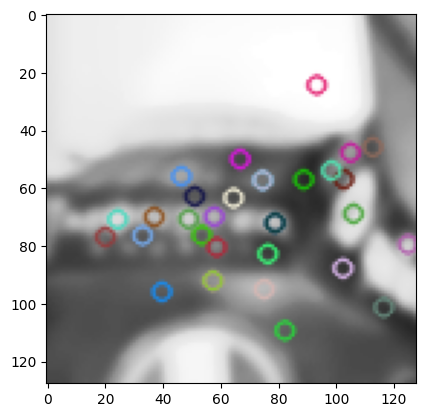

[1] [0.71709868]


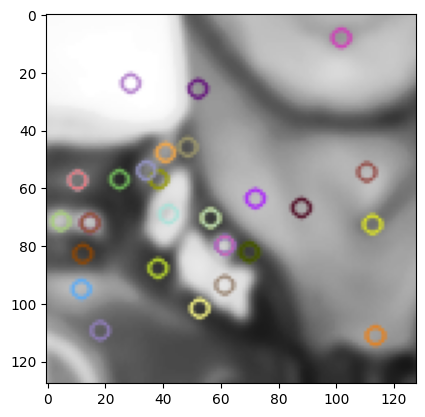

[0] [0.46184186]


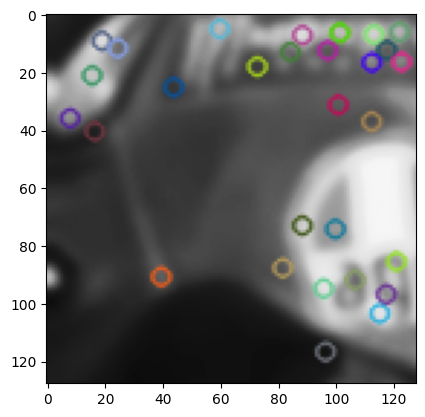

[0] [0.61138121]


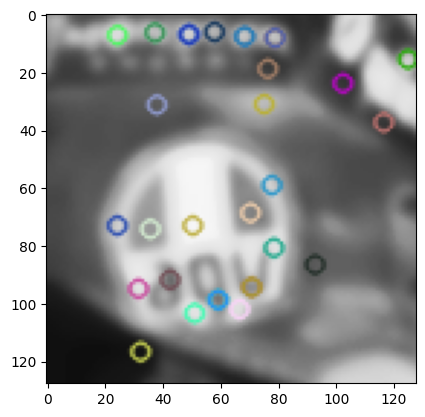

[0] [0.60781543]


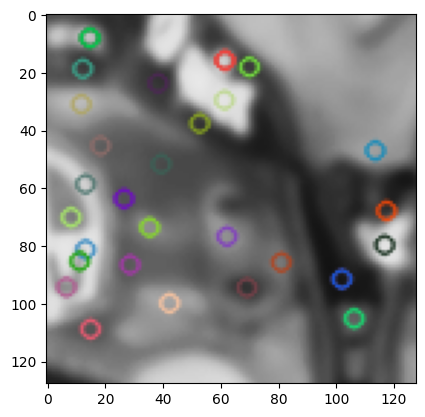

[0] [0.59540019]


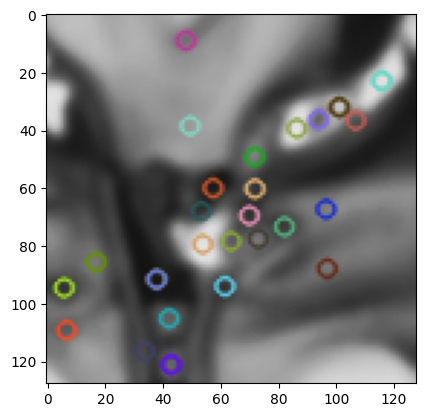

[0] [0.34855156]


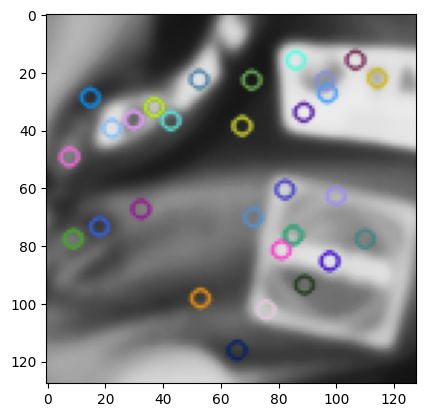

[1] [0.80816782]


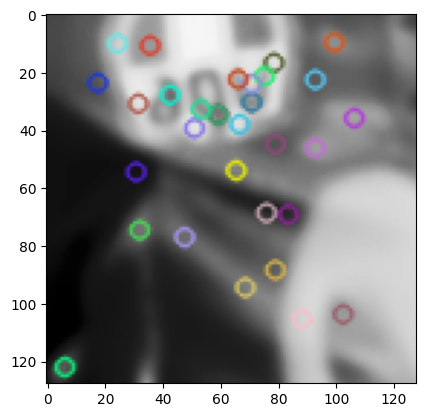

[1] [0.7879238]


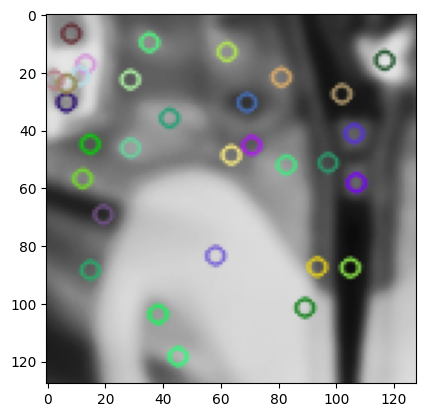

[1] [0.66724891]


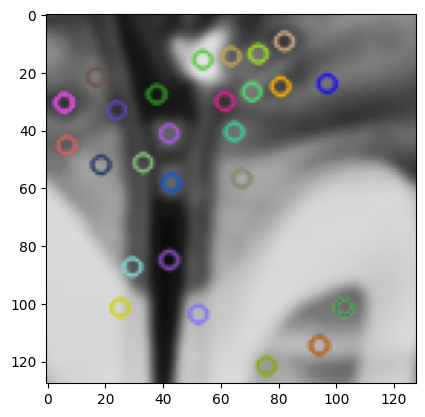

[0] [0.24224253]


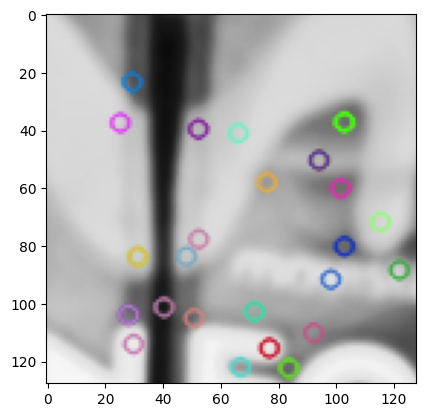

In [36]:
pipeline_save_path = pc.DATA_PATH+"/sift_features_32.pkl"
image_path = pc.DATA_PATH+"/final/Valentino_Rossi_2017.jpg"

pipeline = joblib.load(pipeline_save_path)

image = mpimg.imread(image_path)

keypoints = pc.detect_faces(image, pipeline, threshold=0.65, window_size=(128, 128), step_size=(64, 64), n_keypoints=32, resize=False)


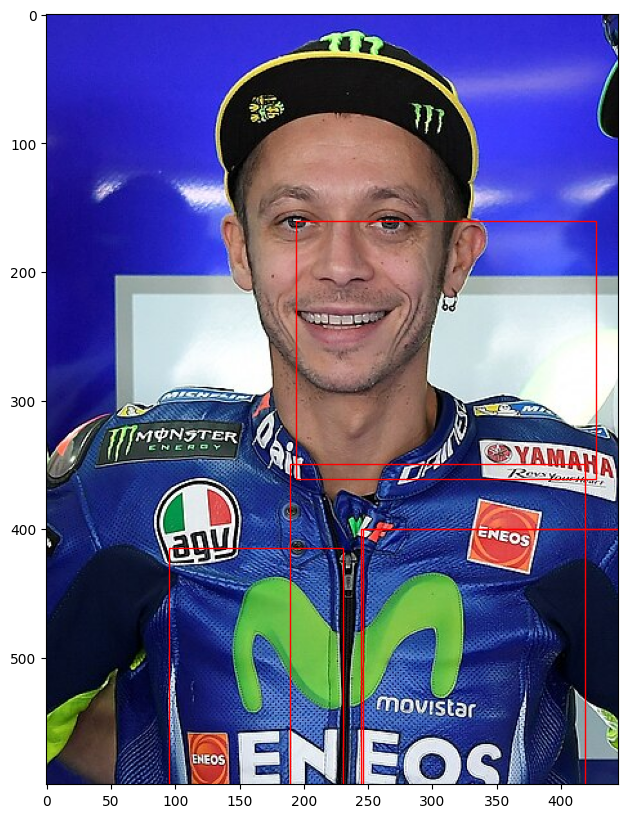

In [37]:
#print image with faces detected
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image)
for kp in keypoints:
    rect = patches.Rectangle((kp[0], kp[1]), kp[0]+40, kp[1]+40, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
